In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [2]:
# Cài đặt giải nén file csv.7z
!pip -q install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.8/428.8 kB 31.3 MB/s eta 0:00:00


In [3]:
# Import thư viện cần thiết
import pandas as pd
import warnings
import py7zr
import os, gc
import re
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import sys
from IPython import get_ipython
import torch
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
# Danh sách các file CSV muốn giải nén
files_to_extract = [
    'train.csv',
    'transactions.csv',
    'stores.csv',
    'oil.csv',
    'items.csv',
    'holidays_events.csv'
]

# Thư mục đích để giải nén
extract_path = "/kaggle/working"
os.makedirs(extract_path, exist_ok=True) # Đảm bảo thư mục đích tồn tại

print("Bắt đầu giải nén các file được chọn...")

for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        archive_path = os.path.join(dirname, filename)
        try:
            # Mở file 7z
            with py7zr.SevenZipFile(archive_path, mode='r') as archive:
                # Lặp qua các file muốn giải nén
                for file_to_extract in files_to_extract:
                    print(f"  Đang giải nén: {file_to_extract}")
                    # Sử dụng extract() để chỉ giải nén file mong muốn
                    archive.extract(path=extract_path, targets=[file_to_extract])

            print("Giải nén hoàn tất các file được chọn.")

        except py7zr.Bad7zFile:
            print(f"Lỗi: File {filename} không phải là file 7z hợp lệ hoặc bị hỏng.")
        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file {archive_path}.")
        except Exception as e:
            print(f"Đã xảy ra lỗi: {e}")


# Kiểm tra lại các file đã được giải nén trong thư mục working
print("\n--- Danh sách file trong thư mục 'working' ---")
# Sử dụng 'ls -l' để hiển thị chi tiết hơn
print(check_output(["ls", "-l", "../working"]).decode("utf8"))

Bắt đầu giải nén các file được chọn...
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang g

# Cắt bỏ dữ liệu chỉ giữ năm 2016-2017 để phân tích

In [5]:
# Hàm hỗ trợ để đọc, chuyển đổi ngày và lọc dữ liệu
def prune_data(filename):
    """Đọc file CSV, lọc các bản ghi có năm 2016-2017, và trả về DataFrame."""
    
    # Đọc file CSV
    df = pd.read_csv(filename, low_memory=False)
    
    # Chuyển đổi cột 'date' thành kiểu datetime để dễ dàng lọc
    df['date'] = pd.to_datetime(df['date'])
    
    # 3. Lọc dữ liệu cho năm 2016-2017
    # Lấy năm từ cột 'date' và so sánh
    df_pruned = df[df['date'].dt.year.isin([2016, 2017])].copy()
    
    # Trả về DataFrame đã được cắt tỉa
    return df_pruned

In [6]:
# 1. train.csv
train_pruned = prune_data("train.csv")
print(f"train_pruned: {len(train_pruned)} bản ghi đã được tải (2016-2017).")

# 2. transactions.csv
transactions_pruned = prune_data("transactions.csv")
print(f"transactions_pruned: {len(transactions_pruned)} bản ghi đã được tải (2016-2017).")

# 3. oil.csv
oil_pruned = prune_data("oil.csv")
print(f"oil_pruned: {len(oil_pruned)} bản ghi đã được tải (2016-2017).")

# 4. holidays_events.csv
holidays_pruned = prune_data("holidays_events.csv")
print(f"holidays_pruned: {len(holidays_pruned)} bản ghi đã được tải (2016-2017).")


# --- Kết quả ---
print("\nĐã lọc và lưu toàn bộ dữ liệu năm 2016-2017 thành công!")

train_pruned: 59038132 bản ghi đã được tải (2016-2017).
transactions_pruned: 31096 bản ghi đã được tải (2016-2017).
oil_pruned: 435 bản ghi đã được tải (2016-2017).
holidays_pruned: 139 bản ghi đã được tải (2016-2017).

Đã lọc và lưu toàn bộ dữ liệu năm 2016-2017 thành công!


In [7]:
# Kiểm tra
print("Kiểm tra 5 dòng đầu tâp train")
print(train_pruned.head())

print("\nKiểm tra 5 dòng đầu của transactions")
print(transactions_pruned.head())

print("\nKiểm tra 5 dòng đầu của oil")
print(oil_pruned.head())

print("\nKiểm tra 5 dòng đầu của holidays_events")
print(holidays_pruned.head())

Kiểm tra 5 dòng đầu tâp train
                id       date  store_nbr  item_nbr  unit_sales onpromotion
66458908  66458908 2016-01-01         25    105574        12.0       False
66458909  66458909 2016-01-01         25    105575         9.0       False
66458910  66458910 2016-01-01         25    105857         3.0       False
66458911  66458911 2016-01-01         25    108634         3.0       False
66458912  66458912 2016-01-01         25    108701         2.0        True

Kiểm tra 5 dòng đầu của transactions
            date  store_nbr  transactions
52392 2016-01-02          2             6
52393 2016-01-02         16           373
52394 2016-01-02         20          1816
52395 2016-01-02         21          1388
52396 2016-01-02         22           849

Kiểm tra 5 dòng đầu của oil
          date  dcoilwtico
783 2016-01-01         NaN
784 2016-01-04       36.81
785 2016-01-05       35.97
786 2016-01-06       33.97
787 2016-01-07       33.29

Kiểm tra 5 dòng đầu của

# Tiền xử lý dữ liệu

## Các hàm tiện ích

In [8]:
def check_null(df: pd.DataFrame) -> dict:
    """Trả về số lượng giá trị null theo từng cột (Pandas) dưới dạng dict."""
    return df.isnull().sum().to_dict()

def check_duplicate(df: pd.DataFrame) -> int:
    """
    Trả về tổng số dòng trùng lặp trong DataFrame (Pandas).
    """
    dup_count = df.duplicated().sum()
    print(f"Số dòng trùng lặp: {dup_count}")
    return dup_count
    
def check_negative(df: pd.DataFrame) -> dict:
    """
    Trả về tổng số giá trị âm trong từng cột số (dưới dạng dict).
    """
    # Lọc danh sách cột kiểu số (integer/float)
    numeric_df = df.select_dtypes(include=np.number)
    return (numeric_df < 0).sum().to_dict()

def check_strange_char(df: pd.DataFrame, pattern=r"[^a-zA-Z0-9\s.,:/\-_]") -> dict:
    """
    Kiểm tra số lượng giá trị chứa ký tự lạ (ngoài chữ,số,khoảng trắng và vài dấu cơ bản) trong các cột chuỗi.
    (Phiên bản đã sửa lỗi)
    """
    # Lọc danh sách cột kiểu chuỗi (object)
    str_cols = df.select_dtypes(include='object').columns.tolist()
    results = {}

    for c in str_cols:
        try:
            count = int(df[c].astype(str).str.contains(pattern).sum())
            results[c] = count
        except Exception as e:
            print(f"Không thể xử lý cột '{c}': {e}")
            results[c] = 0

    return results

# Tạo feature về thời gian (season)- mùa trong năm
def season_from_month(m):
    if m in [12, 1, 2]: return 0  # Winter
    elif m in [3, 4, 5]: return 1  # Spring
    elif m in [6, 7, 8]: return 2  # Summer
    else: return 3  # Fall

## Tiền xử lý tập train_pruned

In [9]:
train_pruned.shape

(59038132, 6)

In [10]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(train_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(train_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(train_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đăc biệt: ", check_strange_char(train_pruned))

Tổng số giá trị null:  {'id': 0, 'date': 0, 'store_nbr': 0, 'item_nbr': 0, 'unit_sales': 0, 'onpromotion': 0}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {'id': 0, 'store_nbr': 0, 'item_nbr': 0, 'unit_sales': 3879}
Tổng số giá trị có ký tự đăc biệt:  {'onpromotion': 0}


In [11]:
# Xử lý giá trị < 0 trong unit_sales
negative_before = (train_pruned['unit_sales'] < 0).sum()
print(f"Số giá trị 'unit_sales' âm (trước khi sửa): {negative_before}")

# Một số dòng có unit_sales < 0 → thay bằng 0 đại diện cho không bán được
train_pruned['unit_sales'] = train_pruned['unit_sales'].clip(lower=0)

# --- Kiểm tra lại kết quả ---
negative_after = (train_pruned['unit_sales'] < 0).sum()
print(f"Số giá trị 'unit_sales' < 0 (sau khi sửa): {negative_after}")

if negative_after == 0:
    print("Đã cập nhật thành công: Tất cả giá trị < 0 trong 'unit_sales' đã được đổi thành 0")
else:
    print("Lỗi: Vẫn còn giá trị <= 0")

Số giá trị 'unit_sales' âm (trước khi sửa): 3879
Số giá trị 'unit_sales' < 0 (sau khi sửa): 0
Đã cập nhật thành công: Tất cả giá trị < 0 trong 'unit_sales' đã được đổi thành 0


In [12]:
print("Tổng số giá trị âm: ", check_negative(train_pruned))

Tổng số giá trị âm:  {'id': 0, 'store_nbr': 0, 'item_nbr': 0, 'unit_sales': 0}


Đang tạo boxplot cho cột: id...
Đang tạo boxplot cho cột: store_nbr...
Đang tạo boxplot cho cột: item_nbr...
Đang tạo boxplot cho cột: unit_sales...


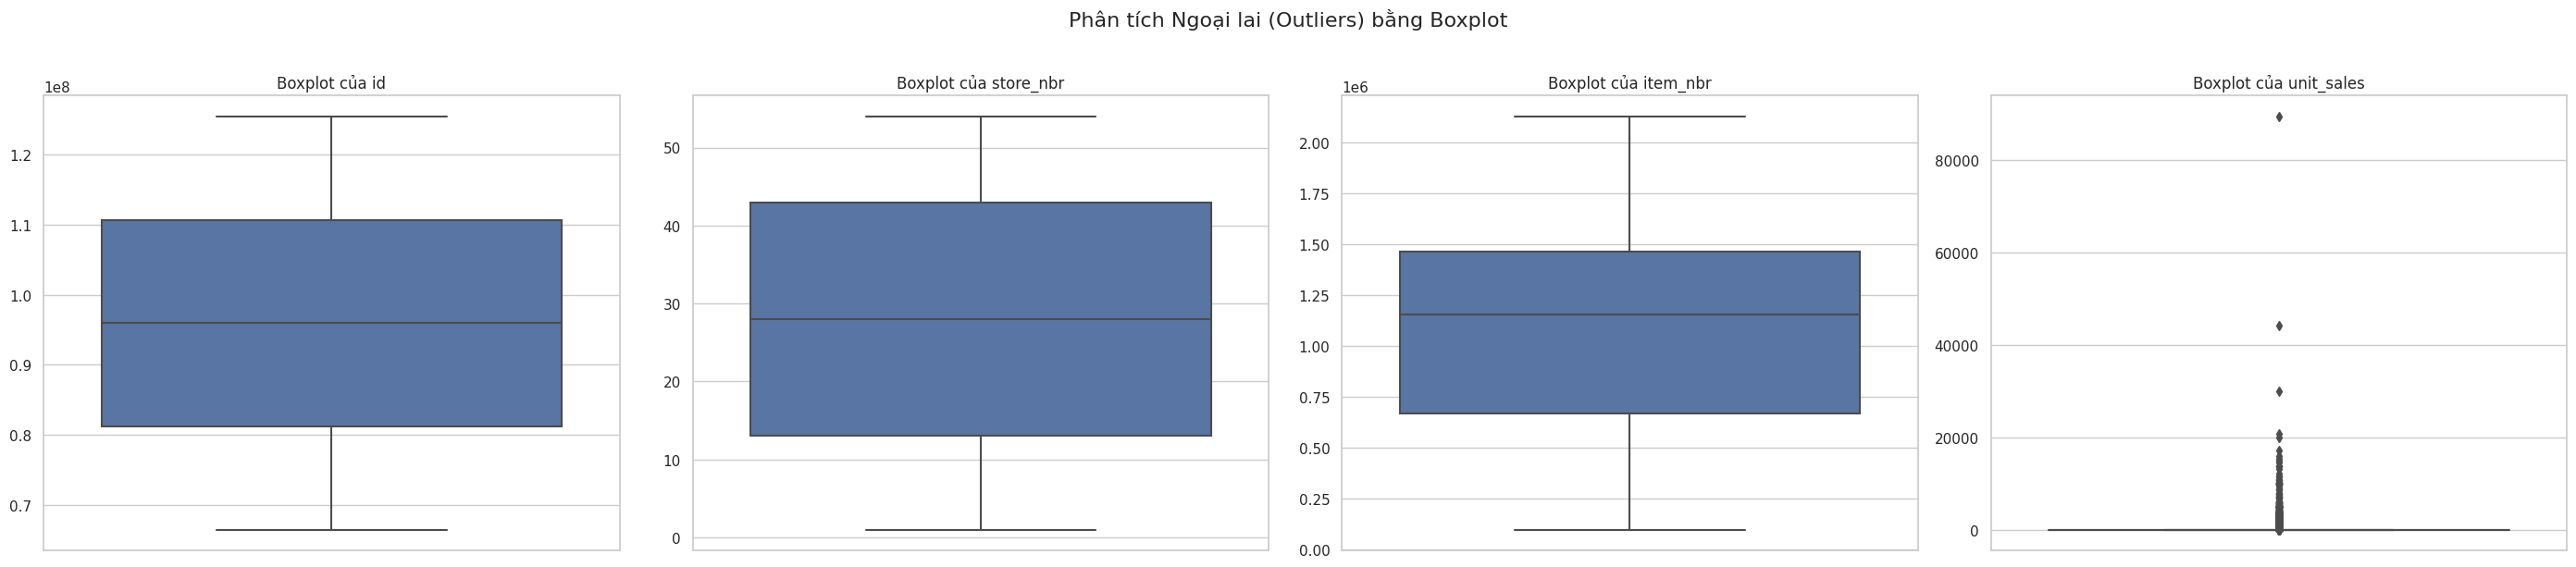

In [13]:
# Trực quan dữ liệu để kiểm tra outlier
sns.set_theme(style="whitegrid")

# Danh sách các cột kiểm tra outlier
cols_to_plot = ['id', 'store_nbr', 'item_nbr', 'unit_sales']

n_features = len(cols_to_plot)

# Vẽ Boxplot
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(7 * n_features, 6))

# Đặt tiêu đề chung cho tất cả biểu đồ
fig.suptitle('Phân tích Ngoại lai (Outliers) bằng Boxplot', fontsize=16, y=1.02)

if n_features == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    print(f"Đang tạo boxplot cho cột: {col}...")
    
    sns.boxplot(data=train_pruned, y=col, ax=axes[i])
    
    axes[i].set_title(f"Boxplot của {col}", fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [14]:
# Danh sách các cột cần kiểm tra outlier
cols_to_check = ['unit_sales']
total_rows = len(train_pruned)
print(f"Tổng số dòng trong DataFrame: {total_rows}\n")

print("--- Thống kê Outlier bằng phương pháp IQR ---")

for col in cols_to_check:
    # 1. Tính Q1 (Quartile 1) và Q3 (Quartile 3)
    Q1 = train_pruned[col].quantile(0.25)
    Q3 = train_pruned[col].quantile(0.75)
    
    # 2. Tính IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # 3. Xác định Ngưỡng Outlier
    # Ngưỡng dưới: Q1 - 1.5 * IQR
    # Ngưỡng trên: Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 4. Đếm số lượng Outlier
    outliers = train_pruned[
        (train_pruned[col] < lower_bound) | (train_pruned[col] > upper_bound)
    ]
    
    num_outliers = len(outliers)
    
    # 5. Tính Tỷ lệ
    outlier_ratio = (num_outliers / total_rows) * 100
    
    print(f"Cột: {col}")
    print(f"Số lượng Outlier: {num_outliers}")
    print(f"Tỷ lệ Outlier: {outlier_ratio:.4f}%")
    
    if col == 'unit_sales':
        print(f"  --> Q1: {Q1:.2f}, Q3: {Q3:.2f}, Ngưỡng Trên: {upper_bound:.2f}")


Tổng số dòng trong DataFrame: 59038132

--- Thống kê Outlier bằng phương pháp IQR ---
Cột: unit_sales
Số lượng Outlier: 5832099
Tỷ lệ Outlier: 9.8785%
  --> Q1: 2.00, Q3: 8.00, Ngưỡng Trên: 17.00


Nhận xét: Khoảng 9.88% số lượng bán hàng được xác định là outlier theo phương pháp IQR (ngưỡng trên là $\mathbf{17}$ đơn vị). Tỷ lệ này là đáng kể nhưng thường thấy trong dữ liệu bán lẻ. Thay vì xóa các outlier này, chúng ta sẽ giữ lại chúng. Các giá trị unit_sales lớn này có thể đại diện cho các sự kiện bán hàng có ý nghĩa thực tế như các đợt khuyến mãi lớn, mùa lễ hội, hoặc tích trữ hàng hóa. Việc xóa chúng sẽ làm mất đi thông tin quan trọng mà mô hình cần học để dự báo các sự kiện đột biến trong tương lai.

In [15]:
# Chuyển cột onpromotion từ bool sang binary (0 và 1)
train_pruned['onpromotion'] = train_pruned['onpromotion'].astype('int8')
train_pruned.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
66458908,66458908,2016-01-01,25,105574,12.0,0
66458909,66458909,2016-01-01,25,105575,9.0,0
66458910,66458910,2016-01-01,25,105857,3.0,0
66458911,66458911,2016-01-01,25,108634,3.0,0
66458912,66458912,2016-01-01,25,108701,2.0,1


In [16]:
# Thêm các cột thời gian

train_pruned['year'] = train_pruned['date'].dt.year
train_pruned['month'] = train_pruned['date'].dt.month
train_pruned['day'] = train_pruned['date'].dt.day
train_pruned['dayofweek'] = train_pruned['date'].dt.dayofweek

train_pruned["weekofyear"] = train_pruned["date"].dt.isocalendar().week.astype(int)
train_pruned["is_weekend"] = train_pruned["dayofweek"].isin([5, 6]).astype(int)
train_pruned["quarter"] = train_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
train_pruned["is_month_start"] = train_pruned["date"].dt.is_month_start.astype(int)
train_pruned["is_month_end"] = train_pruned["date"].dt.is_month_end.astype(int)

train_pruned["season"] = train_pruned["month"].apply(season_from_month)


# --- Kiểm tra kết quả ---
print("\nĐã thêm các cột thành công!")
print("Kiểm tra 5 dòng đầu của train_pruned (với cột mới):")
print(train_pruned.head())


Đã thêm các cột thành công!
Kiểm tra 5 dòng đầu của train_pruned (với cột mới):
                id       date  store_nbr  item_nbr  unit_sales  onpromotion  \
66458908  66458908 2016-01-01         25    105574        12.0            0   
66458909  66458909 2016-01-01         25    105575         9.0            0   
66458910  66458910 2016-01-01         25    105857         3.0            0   
66458911  66458911 2016-01-01         25    108634         3.0            0   
66458912  66458912 2016-01-01         25    108701         2.0            1   

          year  month  day  dayofweek  weekofyear  is_weekend  quarter  \
66458908  2016      1    1          4          53           0        1   
66458909  2016      1    1          4          53           0        1   
66458910  2016      1    1          4          53           0        1   
66458911  2016      1    1          4          53           0        1   
66458912  2016      1    1          4          53           0        1   

In [17]:
# Bỏ cột id
train_pruned = train_pruned.drop('id', axis=1)
print("Các cột hiện tại của train_pruned:")
print(train_pruned.columns)

Các cột hiện tại của train_pruned:
Index(['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year',
       'month', 'day', 'dayofweek', 'weekofyear', 'is_weekend', 'quarter',
       'is_month_start', 'is_month_end', 'season'],
      dtype='object')


In [18]:
train_pruned.shape

(59038132, 15)

In [19]:
# Ghi file csv
train_pruned.to_csv("train_final.csv", index=False)
print("Đã xuất file thành công!")

Đã xuất file thành công!


## Tiền xử lý tập transactions_pruned

In [20]:
transactions_pruned.shape

(31096, 3)

In [21]:
transactions_pruned.head()

,date,store_nbr,transactions
52392,2016-01-02,2,6
52393,2016-01-02,16,373
52394,2016-01-02,20,1816
52395,2016-01-02,21,1388
52396,2016-01-02,22,849


In [22]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(transactions_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(transactions_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(transactions_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đặc biệt: ", check_strange_char(transactions_pruned))

Tổng số giá trị null:  {'date': 0, 'store_nbr': 0, 'transactions': 0}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {'store_nbr': 0, 'transactions': 0}
Tổng số giá trị có ký tự đặc biệt:  {}


Đang tạo boxplot cho cột: store_nbr...
Đang tạo boxplot cho cột: transactions...


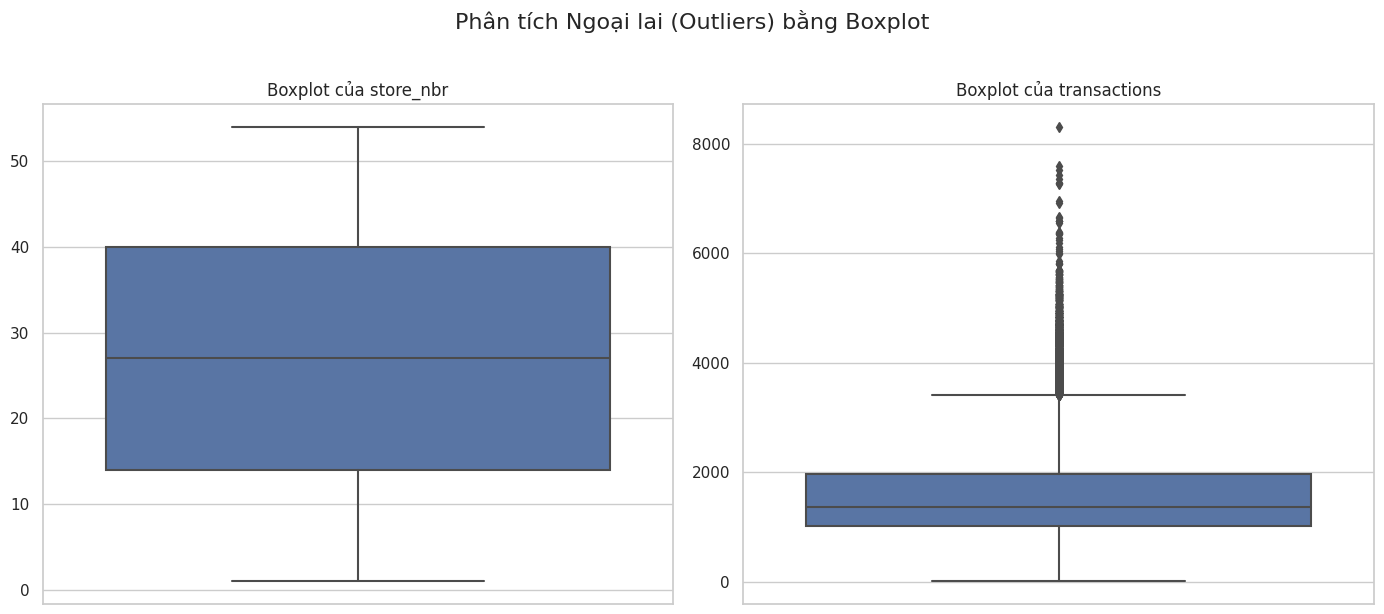

In [23]:
# Trực quan dữ liệu để kiểm tra outlier
sns.set_theme(style="whitegrid")

# Danh sách các cột kiểm tra outlier
cols_to_plot = ['store_nbr', 'transactions']

n_features = len(cols_to_plot)

# Vẽ Boxplot
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(7 * n_features, 6))

# Đặt tiêu đề chung cho tất cả biểu đồ
fig.suptitle('Phân tích Ngoại lai (Outliers) bằng Boxplot', fontsize=16, y=1.02)

if n_features == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    print(f"Đang tạo boxplot cho cột: {col}...")
    
    sns.boxplot(data=transactions_pruned, y=col, ax=axes[i])
    
    axes[i].set_title(f"Boxplot của {col}", fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [24]:
# Xác định ngưỡng Outlier cho 'transactions' (dựa trên phương pháp IQR)
Q1 = transactions_pruned['transactions'].quantile(0.25)
Q3 = transactions_pruned['transactions'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f"Ngưỡng Q1: {Q1}")
print(f"Ngưỡng Q3: {Q3}")
print(f"Ngưỡng Outlier (Giới hạn trên = Q3 + 1.5*IQR): {upper_bound:.2f}")

# Lọc tất cả các ngày có transactions được coi là ngoại lai
outlier_trans_df = transactions_pruned[
    transactions_pruned['transactions'] > upper_bound
].copy()

print(f"\nTìm thấy {len(outlier_trans_df)} ngày có transactions là ngoại lai (cao hơn {upper_bound:.2f}).")

Ngưỡng Q1: 1011.0
Ngưỡng Q3: 1971.0
Ngưỡng Outlier (Giới hạn trên = Q3 + 1.5*IQR): 3411.00

Tìm thấy 2092 ngày có transactions là ngoại lai (cao hơn 3411.00).


In [25]:
outlier_trans_df

,date,store_nbr,transactions
52418,2016-01-02,44,4539
52419,2016-01-02,45,4840
52420,2016-01-02,46,5256
52421,2016-01-02,47,4967
52422,2016-01-02,48,4574
...,...,...,...
83424,2017-08-14,45,3743
83426,2017-08-14,47,3606
83477,2017-08-15,44,3815
83478,2017-08-15,45,3685


Ghi chú: Các giá trị transactions tăng đột biến vào các ngày như 2016-01-02, 2016-12-23, 2017-08-14 và 2017-08-15 được xác định là outlier về mặt thống kê, tuy nhiên đều là outlier hợp lý. Cụ thể, những thời điểm này trùng với mùa mua sắm lễ Tết Dương lịch, cao điểm Giáng sinh, và lễ Đức Mẹ Lên Trời – các dịp người dân Ecuador thường mua sắm, du lịch và tổ chức lễ hội nhiều hơn bình thường. Vì vậy, các outlier này phản ánh biến động thực tế trong hành vi tiêu dùng, không phải dữ liệu bất thường hay lỗi, nên được giữ lại trong phân tích.

In [26]:
# Thêm các cột thời gian

transactions_pruned['year'] = transactions_pruned['date'].dt.year
transactions_pruned['month'] = transactions_pruned['date'].dt.month
transactions_pruned['day'] = transactions_pruned['date'].dt.day
transactions_pruned['dayofweek'] = transactions_pruned['date'].dt.dayofweek

transactions_pruned["weekofyear"] = transactions_pruned["date"].dt.isocalendar().week.astype(int)
transactions_pruned["is_weekend"] = transactions_pruned["dayofweek"].isin([5, 6]).astype(int)
transactions_pruned["quarter"] = transactions_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
transactions_pruned["is_month_start"] = transactions_pruned["date"].dt.is_month_start.astype(int)
transactions_pruned["is_month_end"] = transactions_pruned["date"].dt.is_month_end.astype(int)

transactions_pruned["season"] = transactions_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm cột thành công!")
print("Kiểm tra 5 dòng đầu của transactions_pruned (với cột mới):")
print(transactions_pruned.head())


Đã thêm cột thành công!
Kiểm tra 5 dòng đầu của transactions_pruned (với cột mới):
            date  store_nbr  transactions  year  month  day  dayofweek  \
52392 2016-01-02          2             6  2016      1    2          5   
52393 2016-01-02         16           373  2016      1    2          5   
52394 2016-01-02         20          1816  2016      1    2          5   
52395 2016-01-02         21          1388  2016      1    2          5   
52396 2016-01-02         22           849  2016      1    2          5   

       weekofyear  is_weekend  quarter  is_month_start  is_month_end  season  
52392          53           1        1               0             0       0  
52393          53           1        1               0             0       0  
52394          53           1        1               0             0       0  
52395          53           1        1               0             0       0  
52396          53           1        1               0             0       0

In [27]:
# Ghi file csv
transactions_pruned.to_csv("transactions_final.csv", index=False)
print("Đã xuất file thành công!")

Đã xuất file thành công!


## Tiền xử lý tập oil_pruned

In [28]:
oil_pruned.shape

(435, 2)

In [29]:
oil_pruned.head()

,date,dcoilwtico
783,2016-01-01,NaN
784,2016-01-04,36.81
785,2016-01-05,35.97
786,2016-01-06,33.97
787,2016-01-07,33.29


In [30]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(oil_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(oil_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(oil_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đặc biệt: ", check_strange_char(oil_pruned))

Tổng số giá trị null:  {'date': 0, 'dcoilwtico': 16}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {'dcoilwtico': 0}
Tổng số giá trị có ký tự đặc biệt:  {}


In [31]:
# Kiểm tra thông tin dữ liệu có dcoilwtico bị null
oil_pruned[oil_pruned['dcoilwtico'].isnull()]

,date,dcoilwtico
783,2016-01-01,NaN
794,2016-01-18,NaN
814,2016-02-15,NaN
843,2016-03-25,NaN
889,2016-05-30,NaN
914,2016-07-04,NaN
959,2016-09-05,NaN
1017,2016-11-24,NaN
1039,2016-12-26,NaN
1044,2017-01-02,NaN


In [32]:
# Xử lý null
print(f"Số lượng giá trị null trong 'dcoilwtico' ban đầu: {oil_pruned['dcoilwtico'].isnull().sum()}")

# Sử dụng 'ffill' (forward fill) để fill giá trị null bằng giá trị của ngày trước đó
oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='ffill')

# Xử lý trường hợp đặc biệt nếu phía trước dữ liệu null không có dữ liệu nào trước đó -> Dùng 'bfill' (backward fill)
oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='bfill')

# Kiểm tra lại
final_null_count = oil_pruned['dcoilwtico'].isnull().sum()
print(f"Số lượng giá trị null trong 'dcoilwtico' sau khi fill: {final_null_count}")

if final_null_count == 0:
    print("Đã fill thành công!")
else:
    print("Vẫn còn giá trị null, vui lòng kiểm tra lại.")

Số lượng giá trị null trong 'dcoilwtico' ban đầu: 16
Số lượng giá trị null trong 'dcoilwtico' sau khi fill: 0
Đã fill thành công!


/tmp/ipykernel_48/2972458142.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='ffill')
/tmp/ipykernel_48/2972458142.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='bfill')


In [33]:
# Thêm các cột thời gian

oil_pruned['year'] = oil_pruned['date'].dt.year
oil_pruned['month'] = oil_pruned['date'].dt.month
oil_pruned['day'] = oil_pruned['date'].dt.day
oil_pruned['dayofweek'] = oil_pruned['date'].dt.dayofweek

oil_pruned["weekofyear"] = oil_pruned["date"].dt.isocalendar().week.astype(int)
oil_pruned["is_weekend"] = oil_pruned["dayofweek"].isin([5, 6]).astype(int)
oil_pruned["quarter"] = oil_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
oil_pruned["is_month_start"] = oil_pruned["date"].dt.is_month_start.astype(int)
oil_pruned["is_month_end"] = oil_pruned["date"].dt.is_month_end.astype(int)

oil_pruned["season"] = oil_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm cột thành công!")
print("Kiểm tra 5 dòng đầu của oil_pruned (với cột mới):")
print(oil_pruned.head())


Đã thêm cột thành công!
Kiểm tra 5 dòng đầu của oil_pruned (với cột mới):
          date  dcoilwtico  year  month  day  dayofweek  weekofyear  \
783 2016-01-01       36.81  2016      1    1          4          53   
784 2016-01-04       36.81  2016      1    4          0           1   
785 2016-01-05       35.97  2016      1    5          1           1   
786 2016-01-06       33.97  2016      1    6          2           1   
787 2016-01-07       33.29  2016      1    7          3           1   

     is_weekend  quarter  is_month_start  is_month_end  season  
783           0        1               1             0       0  
784           0        1               0             0       0  
785           0        1               0             0       0  
786           0        1               0             0       0  
787           0        1               0             0       0  


Đang tạo boxplot cho cột: dcoilwtico...


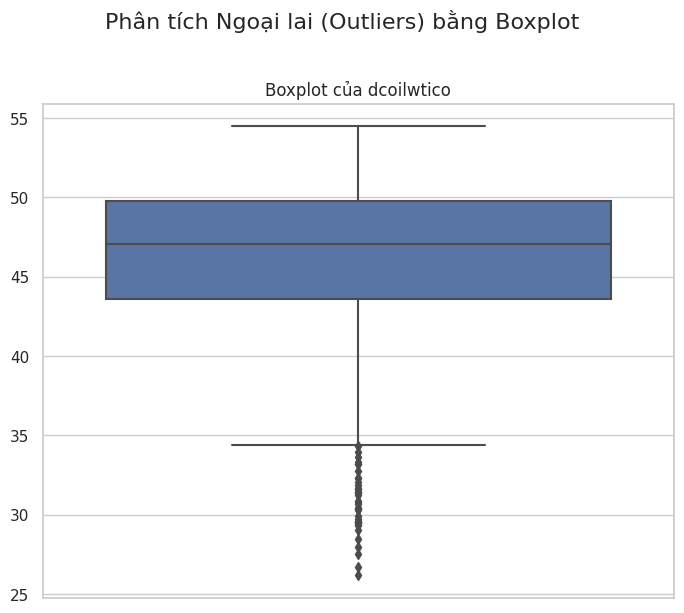

In [34]:
# Trực quan dữ liệu để kiểm tra outlier
sns.set_theme(style="whitegrid")

# Danh sách các cột kiểm tra outlier
cols_to_plot = ['dcoilwtico']

n_features = len(cols_to_plot)

# Vẽ Boxplot
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(7 * n_features, 6))

# Đặt tiêu đề chung cho tất cả biểu đồ
fig.suptitle('Phân tích Ngoại lai (Outliers) bằng Boxplot', fontsize=16, y=1.02)

if n_features == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    print(f"Đang tạo boxplot cho cột: {col}...")
    
    sns.boxplot(data=oil_pruned, y=col, ax=axes[i])
    
    axes[i].set_title(f"Boxplot của {col}", fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [35]:
# Xác định ngưỡng Outlier cho 'dcoilwtico' (dựa trên phương pháp IQR)
Q1 = oil_pruned['dcoilwtico'].quantile(0.25)
Q3 = oil_pruned['dcoilwtico'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR

print(f"Ngưỡng Q1: {Q1}")
print(f"Ngưỡng Q3: {Q3}")
print(f"Ngưỡng Outlier (Giới hạn dưới = Q1 - 1.5*IQR): {lower_bound:.2f}")

# Lọc tất cả các ngày có dcoilwtico được coi là ngoại lai
outlier_oil_df = oil_pruned[
    oil_pruned['dcoilwtico'] < lower_bound
].copy()

print(f"\nTìm thấy {len(outlier_oil_df)} ngày có dcoilwtico là ngoại lai (thấp hơn {lower_bound:.2f}).")

Ngưỡng Q1: 43.565
Ngưỡng Q3: 49.735
Ngưỡng Outlier (Giới hạn dưới = Q1 - 1.5*IQR): 34.31

Tìm thấy 40 ngày có dcoilwtico là ngoại lai (thấp hơn 34.31).


In [36]:
outlier_oil_df

,date,dcoilwtico,year,month,day,dayofweek,weekofyear,is_weekend,quarter,is_month_start,is_month_end,season
786,2016-01-06,33.97,2016,1,6,2,1,0,1,0,0,0
787,2016-01-07,33.29,2016,1,7,3,1,0,1,0,0,0
788,2016-01-08,33.20,2016,1,8,4,1,0,1,0,0,0
789,2016-01-11,31.42,2016,1,11,0,2,0,1,0,0,0
790,2016-01-12,30.42,2016,1,12,1,2,0,1,0,0,0
791,2016-01-13,30.42,2016,1,13,2,2,0,1,0,0,0
792,2016-01-14,31.22,2016,1,14,3,2,0,1,0,0,0
793,2016-01-15,29.45,2016,1,15,4,2,0,1,0,0,0
794,2016-01-18,29.45,2016,1,18,0,3,0,1,0,0,0
795,2016-01-19,28.47,2016,1,19,1,3,0,1,0,0,0


Nhận xét: Trong đầu năm 2016, giá dầu thế giới thực sự giảm rất mạnh, có lúc chạm ~26–30 USD/thùng do: Khủng hoảng cung – cầu dầu mỏ, OPEC không cắt giảm sản lượng, nhu cầu từ Trung Quốc giảm mạnh, và tồn kho dầu ở Mỹ cao kỷ lục -> Các giá trị outlier phản ánh biến động thật của giá dầu, không phải thiếu hoặc lỗi dữ liệu -> Giữ lại các outlier

In [37]:
# Ghi file csv
oil_pruned.to_csv("oil_final.csv", index=False)
print("Đã xuất file thành công!")

Đã xuất file thành công!


## Tiền xử lý tập holidays_pruned

In [38]:
holidays_pruned.shape

(139, 6)

In [39]:
holidays_pruned.head()

,date,type,locale,locale_name,description,transferred
211,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,False
212,2016-02-08,Holiday,National,Ecuador,Carnaval,False
213,2016-02-09,Holiday,National,Ecuador,Carnaval,False
214,2016-03-02,Holiday,Local,Manta,Fundacion de Manta,False
215,2016-03-25,Holiday,National,Ecuador,Viernes Santo,False


In [40]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(holidays_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(holidays_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(holidays_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đặc biệt: ", check_strange_char(holidays_pruned))

Tổng số giá trị null:  {'date': 0, 'type': 0, 'locale': 0, 'locale_name': 0, 'description': 0, 'transferred': 0}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {}
Tổng số giá trị có ký tự đặc biệt:  {'type': 0, 'locale': 0, 'locale_name': 0, 'description': 32}


In [41]:
# Định nghĩa pattern ký tự đặc biệt (có thể tinh chỉnh)
pattern = r"[^a-zA-Z0-9\s.,:/\-_]"

condition = holidays_pruned["description"].str.contains(pattern, na=False)

rows_with_special = holidays_pruned[condition]

# In kết quả
print(f"Số dòng chứa ký tự đặc biệt: {len(rows_with_special)}")

print("\n--- Hiển thị các dòng chứa ký tự đặc biệt ---")

print(rows_with_special)

Số dòng chứa ký tự đặc biệt: 32

--- Hiển thị các dòng chứa ký tự đặc biệt ---
          date        type    locale locale_name          description  \
220 2016-04-17       Event  National     Ecuador   Terremoto Manabi+1   
221 2016-04-18       Event  National     Ecuador   Terremoto Manabi+2   
222 2016-04-19       Event  National     Ecuador   Terremoto Manabi+3   
223 2016-04-20       Event  National     Ecuador   Terremoto Manabi+4   
225 2016-04-21       Event  National     Ecuador   Terremoto Manabi+5   
226 2016-04-22       Event  National     Ecuador   Terremoto Manabi+6   
227 2016-04-23       Event  National     Ecuador   Terremoto Manabi+7   
228 2016-04-24       Event  National     Ecuador   Terremoto Manabi+8   
229 2016-04-25       Event  National     Ecuador   Terremoto Manabi+9   
230 2016-04-26       Event  National     Ecuador  Terremoto Manabi+10   
231 2016-04-27       Event  National     Ecuador  Terremoto Manabi+11   
232 2016-04-28       Event  National     Ecua

Giải thích: Dấu + (cộng) không phải là dữ liệu lỗi hay ký tự đặc biệt, mà là một ký hiệu ghi chú (notation) có chủ đích. Nó được sử dụng trong cột description để đánh dấu những ngày nghỉ bổ sung hoặc ngày liên quan ngay lập tức sau một sự kiện hoặc ngày lễ chính. Các ngày này thường là "ngày nghỉ bù" (bridge days) hoặc các ngày quan sát/phục hồi sau một sự kiện lớn.

In [42]:
# Chuyển cột transferred từ bool sang binary (0 và 1)
holidays_pruned['transferred'] = holidays_pruned['transferred'].astype('int8')
holidays_pruned.head()

,date,type,locale,locale_name,description,transferred
211,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,0
212,2016-02-08,Holiday,National,Ecuador,Carnaval,0
213,2016-02-09,Holiday,National,Ecuador,Carnaval,0
214,2016-03-02,Holiday,Local,Manta,Fundacion de Manta,0
215,2016-03-25,Holiday,National,Ecuador,Viernes Santo,0


In [43]:
# Thêm các cột thời gian

holidays_pruned['year'] = holidays_pruned['date'].dt.year
holidays_pruned['month'] = holidays_pruned['date'].dt.month
holidays_pruned['day'] = holidays_pruned['date'].dt.day
holidays_pruned['dayofweek'] = holidays_pruned['date'].dt.dayofweek

holidays_pruned["weekofyear"] = holidays_pruned["date"].dt.isocalendar().week.astype(int)
holidays_pruned["is_weekend"] = holidays_pruned["dayofweek"].isin([5, 6]).astype(int)
holidays_pruned["quarter"] = holidays_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
holidays_pruned["is_month_start"] = holidays_pruned["date"].dt.is_month_start.astype(int)
holidays_pruned["is_month_end"] = holidays_pruned["date"].dt.is_month_end.astype(int)

holidays_pruned["season"] = holidays_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm cột thành công!")
print("Kiểm tra 5 dòng đầu của holidays_pruned (với cột mới):")
print(holidays_pruned.head())


Đã thêm cột thành công!
Kiểm tra 5 dòng đầu của holidays_pruned (với cột mới):
          date     type    locale locale_name         description  \
211 2016-01-01  Holiday  National     Ecuador  Primer dia del ano   
212 2016-02-08  Holiday  National     Ecuador            Carnaval   
213 2016-02-09  Holiday  National     Ecuador            Carnaval   
214 2016-03-02  Holiday     Local       Manta  Fundacion de Manta   
215 2016-03-25  Holiday  National     Ecuador       Viernes Santo   

     transferred  year  month  day  dayofweek  weekofyear  is_weekend  \
211            0  2016      1    1          4          53           0   
212            0  2016      2    8          0           6           0   
213            0  2016      2    9          1           6           0   
214            0  2016      3    2          2           9           0   
215            0  2016      3   25          4          12           0   

     quarter  is_month_start  is_month_end  season  
211        1 

In [44]:
# Ghi file csv
holidays_pruned.to_csv("holidays_final.csv", index=False)
print("Đã xuất file thành công!")

Đã xuất file thành công!


## Tiền xử lý tập items

In [45]:
items = pd.read_csv("/kaggle/working/items.csv")

In [46]:
items.shape

(4100, 4)

In [47]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [48]:
# Kiểm tra giá trị null
print("Tổng số giá trị null:\n", items.isnull().sum(), "\n")

# Kiểm tra trùng lặp
print("Số dòng trùng lặp hoàn toàn:", items.duplicated().sum())
print("Số item_nbr trùng:", items.duplicated(subset=['item_nbr']).sum(), "\n")

# Kiểm tra giá trị âm (chỉ các cột numeric)
num_cols = items.select_dtypes(include='number').columns
print("Số giá trị âm theo cột:\n", (items[num_cols] < 0).sum(), "\n")

# Kiểm tra ký tự đặc biệt (chỉ cột string)
pattern = r"[^a-zA-Z0-9\s.,:/\-_+]"
str_cols = items.select_dtypes(include='object').columns
print("Số giá trị có ký tự đặc biệt theo cột:\n",
      items[str_cols].apply(lambda s: s.astype(str).str.contains(pattern, regex=True, na=False).sum()))

Tổng số giá trị null:
 item_nbr      0
family        0
class         0
perishable    0
dtype: int64 

Số dòng trùng lặp hoàn toàn: 0
Số item_nbr trùng: 0 

Số giá trị âm theo cột:
 item_nbr      0
class         0
perishable    0
dtype: int64 

Số giá trị có ký tự đặc biệt theo cột:
 family    0
dtype: int64


## Tiền xử lý tập stores

In [49]:
stores = pd.read_csv("/kaggle/working/stores.csv")

In [50]:
stores.shape

(54, 5)

In [51]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [52]:
# Kiểm tra giá trị null
print("Tổng số giá trị null:\n", stores.isnull().sum(), "\n")

# Kiểm tra trùng lặp
print("Số dòng trùng lặp hoàn toàn:", stores.duplicated().sum())
print("Số store_nbr trùng:", stores.duplicated(subset=['store_nbr']).sum(), "\n")

# Kiểm tra giá trị âm (chỉ các cột numeric)
num_cols = stores.select_dtypes(include='number').columns
print("Số giá trị âm theo cột:\n", (stores[num_cols] < 0).sum(), "\n")

# Kiểm tra ký tự đặc biệt (chỉ cột string)
pattern = r"[^a-zA-Z0-9\s.,:/\-_+]"
str_cols = stores.select_dtypes(include='object').columns
print("Số giá trị có ký tự đặc biệt theo cột:\n",
      stores[str_cols].apply(lambda s: s.astype(str).str.contains(pattern, regex=True, na=False).sum()))

Tổng số giá trị null:
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 

Số dòng trùng lặp hoàn toàn: 0
Số store_nbr trùng: 0 

Số giá trị âm theo cột:
 store_nbr    0
cluster      0
dtype: int64 

Số giá trị có ký tự đặc biệt theo cột:
 city     0
state    0
type     0
dtype: int64


# EDA thống kê cơ bản

In [53]:
# Train
print("Thống kê kiểu dữ liệu: ")
print(train_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả unit_sales:")
print("Min: ", train_pruned['unit_sales'].min())
print("Max: ", train_pruned['unit_sales'].max())

print("\n=====================\n")
print("Thống kê mô tả onpromotion:")
# Tính số lượng và tỷ lệ phần trăm cho mỗi giá trị unique
promotion_counts = train_pruned['onpromotion'].value_counts()
promotion_ratios = train_pruned['onpromotion'].value_counts(normalize=True) * 100

# In kết quả cho 0 (Không Khuyến mãi)
count_0 = promotion_counts.get(0, 0)
ratio_0 = promotion_ratios.get(0, 0)
print(f"0 (Không Khuyến mãi)         | {count_0:<17} | {ratio_0:.4f}%")

# In kết quả cho 1 (Có Khuyến mãi)
count_1 = promotion_counts.get(1, 0)
ratio_1 = promotion_ratios.get(1, 0)
print(f"1 (Có Khuyến mãi)            | {count_1:<17} | {ratio_1:.4f}%")

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
store_nbr                  int64
item_nbr                   int64
unit_sales               float64
onpromotion                 int8
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả unit_sales:
Min:  0.0
Max:  89440.0


Thống kê mô tả onpromotion:
0 (Không Khuyến mãi)         | 52773899          | 89.3895%
1 (Có Khuyến mãi)            | 6264233           | 10.6105%


In [54]:
# Transactions
print("Thống kê kiểu dữ liệu: ")
print(transactions_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả transactions:")
transactions_pruned['transactions'].describe().round()

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
store_nbr                  int64
transactions               int64
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả transactions:


count    31096.0
mean      1642.0
std        939.0
min          5.0
25%       1011.0
50%       1355.0
75%       1971.0
max       8307.0
Name: transactions, dtype: float64

In [55]:
# Oil
print("Thống kê kiểu dữ liệu: ")
print(oil_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả oil:")
oil_pruned['dcoilwtico'].describe().round(2)

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
dcoilwtico               float64
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả oil:


count    435.00
mean      45.66
std        6.34
min       26.19
25%       43.56
50%       47.02
75%       49.74
max       54.48
Name: dcoilwtico, dtype: float64

In [56]:
# Holidays
print("Thống kê kiểu dữ liệu: ")
print(holidays_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả transferred:")
# Tính số lượng và tỷ lệ phần trăm cho mỗi giá trị unique
transferred_counts = holidays_pruned['transferred'].value_counts()
transferred_ratios = holidays_pruned['transferred'].value_counts(normalize=True) * 100

# In kết quả cho 0 (Ngày tổ chức lễ gốc)
count_0 = transferred_counts.get(0, 0)
ratio_0 = transferred_ratios.get(0, 0)
print(f"0 (Ngày tổ chức lễ gốc)                   | {count_0:<17} | {ratio_0:.4f}%")

# In kết quả cho 1 (Ngày tổ chức lễ bị dời sang ngày khác)
count_1 = transferred_counts.get(1, 0)
ratio_1 = transferred_ratios.get(1, 0)
print(f"1 (Ngày tổ chức lễ bị dời sang ngày khác) | {count_1:<17} | {ratio_1:.4f}%")

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
type                      object
locale                    object
locale_name               object
description               object
transferred                 int8
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả transferred:
0 (Ngày tổ chức lễ gốc)                   | 130               | 93.5252%
1 (Ngày tổ chức lễ bị dời sang ngày khác) | 9                 | 6.4748%


In [57]:
# Items
print("Thống kê kiểu dữ liệu: ")
print(items.dtypes)

print("\n=====================\n")
print("Thống kê mô tả perishable:")
# Tính số lượng và tỷ lệ phần trăm cho mỗi giá trị unique
perishable_counts = items['perishable'].value_counts()
perishable_ratios = items['perishable'].value_counts(normalize=True) * 100

# In kết quả cho 0 (Sản phẩm bền)
count_0 = perishable_counts.get(0, 0)
ratio_0 = perishable_ratios.get(0, 0)
print(f"0 (Sản phẩm bền)         | {count_0:<17} | {ratio_0:.4f}%")

# In kết quả cho 1 (Sản phẩm dễ hư hỏng)
count_1 = perishable_counts.get(1, 0)
ratio_1 = perishable_ratios.get(1, 0)
print(f"1 (Sản phẩm dễ hư hỏng)  | {count_1:<17} | {ratio_1:.4f}%")

Thống kê kiểu dữ liệu: 
item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object


Thống kê mô tả perishable:
0 (Sản phẩm bền)         | 3114              | 75.9512%
1 (Sản phẩm dễ hư hỏng)  | 986               | 24.0488%


In [58]:
# Stores
print("Thống kê kiểu dữ liệu: ")
print(stores.dtypes)

print("\n=====================\n")
print("Thống kê giá trị unique của city/state/type/cluster:")
# Danh sách các cột cần thống kê
cols_to_check = ['city', 'state', 'type', 'cluster']

for col in cols_to_check:
    print(f"\nCột: {col} ({len(stores[col].unique())} giá trị duy nhất)")
    # In ra tất cả các giá trị unique
    print(stores[col].unique())

Thống kê kiểu dữ liệu: 
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object


Thống kê giá trị unique của city/state/type/cluster:

Cột: city (22 giá trị duy nhất)
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']

Cột: state (16 giá trị duy nhất)
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']

Cột: type (5 giá trị duy nhất)
['D' 'B' 'C' 'E' 'A']

Cột: cluster (17 giá trị duy nhất)
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


# Xây dựng mô hình phân tích dự báo

In [59]:
# ===== TRAIN =====
# Sử dụng trực tiếp dữ liệu train_pruned (đã tiền xử lý), chỉ giữ 6 tháng đầu năm 2017
train = train_pruned.copy()
train = train[(train["date"] >= "2017-01-01") & (train["date"] < "2017-07-01")]
print(f"train_pruned (2017-01 -> 2017-06): {train.shape[0]} hàng × {train.shape[1]} cột\n")

# ===== TRANSACTIONS =====
# Dùng lại transactions_pruned đã tiền xử lý
transactions = transactions_pruned.copy()
print(f"transactions_pruned: {transactions.shape[0]} hàng × {transactions.shape[1]} cột\n")

# ===== STORES =====
# stores đã được đọc ở phần tiền xử lý nên chỉ dùng lại
print(f"stores.csv: {stores.shape[0]} hàng × {stores.shape[1]} cột\n")

# ===== ITEMS =====
# items đã được đọc ở phần tiền xử lý nên chỉ dùng lại
print(f"items.csv: {items.shape[0]} hàng × {items.shape[1]} cột\n")

# ===== HOLIDAYS =====
# Dùng lại holidays_pruned đã cắt năm 2016-2017
holidays = holidays_pruned.copy()
print(f"holidays_events (pruned): {holidays.shape[0]} hàng × {holidays.shape[1]} cột\n")

# ===== OIL =====
# Dùng lại oil_pruned đã cắt năm 2016-2017
oil = oil_pruned.copy()
print(f"oil (pruned): {oil.shape[0]} hàng × {oil.shape[1]} cột\n")

# ===== Tổng kết =====
print("Tất cả dữ liệu đã sẵn sàng trong bộ nhớ:")
print({
    "train": train.shape,
    "transactions": transactions.shape,
    "stores": stores.shape,
    "items": items.shape,
    "holidays": holidays.shape,
    "oil": oil.shape,
})


train_pruned (2017-01 -> 2017-06): 18954132 hàng × 15 cột

transactions_pruned: 31096 hàng × 13 cột

stores.csv: 54 hàng × 5 cột

items.csv: 4100 hàng × 4 cột

holidays_events (pruned): 139 hàng × 16 cột

oil (pruned): 435 hàng × 12 cột

Tất cả dữ liệu đã sẵn sàng trong bộ nhớ:
{'train': (18954132, 15), 'transactions': (31096, 13), 'stores': (54, 5), 'items': (4100, 4), 'holidays': (139, 16), 'oil': (435, 12)}


## Merge toàn bộ bảng lại với nhau

In [60]:
# Sao chép train để tránh đụng dữ liệu gốc
train_merged = train.copy()

print("=== MERGING DATASETS ===")
train_merged = pd.merge(train_merged, stores, on="store_nbr", how="left")
train_merged = pd.merge(train_merged, items, on="item_nbr", how="left")
train_merged = pd.merge(train_merged, transactions[["date","store_nbr","transactions"]], on=["date", "store_nbr"], how="left")
train_merged = pd.merge(train_merged, oil[["date", "dcoilwtico"]], on="date", how="left")
train_merged = pd.merge(train_merged, holidays[["date", "type", "locale", "locale_name", "description", "transferred"]], 
                        on="date", how="left")

print("\nMerge hoàn tất.")
print("train_merged:", train_merged.shape)

# Kiểm tra số lượng NA
print("\nMissing values (top 10 cột có NA):")
print(train_merged.isna().sum().sort_values(ascending=False).head(10))

# Xem vài dòng đầu
print("\nPreview:")
print(train_merged.head())


=== MERGING DATASETS ===

Merge hoàn tất.
train_merged: (19280741, 29)

Missing values (top 10 cột có NA):
type_y         17126958
transferred    17126958
description    17126958
locale_name    17126958
locale         17126958
dcoilwtico      5824848
month                 0
year                  0
date                  0
store_nbr             0
dtype: int64

Preview:
        date  store_nbr  item_nbr  unit_sales  onpromotion  year  month  day  \
0 2017-01-01         25     99197         1.0            0  2017      1    1   
1 2017-01-01         25    103665         7.0            0  2017      1    1   
2 2017-01-01         25    105574         1.0            0  2017      1    1   
3 2017-01-01         25    105857         4.0            0  2017      1    1   
4 2017-01-01         25    106716         2.0            0  2017      1    1   

   dayofweek  weekofyear  ...        family  class  perishable  transactions  \
0          6          52  ...     GROCERY I   1067           0       

In [64]:
# # ===== Giải phóng bộ nhớ để tránh tràn =====
# del train, train_pruned, oil, oil_pruned, transactions, transactions_pruned, holidays_pruned, holidays, items, stores
# import gc; gc.collect()
# print("Đã xoá toàn bộ biến nặng trong RAM.")

15849

In [65]:
# ===== Xử lý giá dầu (oil) =====
train_merged["dcoilwtico"] = train_merged["dcoilwtico"].fillna(method="ffill")
train_merged["dcoilwtico"] = train_merged["dcoilwtico"].fillna(method="bfill")


# ===== Xử lý dữ liệu ngày lễ (holidays) =====
train_merged["type_y"].fillna("Work Day", inplace=True)
train_merged["locale"].fillna("None", inplace=True)
train_merged["locale_name"].fillna("None", inplace=True)
train_merged["description"].fillna("Normal Day", inplace=True)
train_merged["transferred"].fillna(False, inplace=True)

print("Đã xử lý toàn bộ missing values.")
print(train_merged.isna().sum().sort_values(ascending=False).head(10))

/tmp/ipykernel_48/2548593489.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_merged["dcoilwtico"] = train_merged["dcoilwtico"].fillna(method="ffill")
/tmp/ipykernel_48/2548593489.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_merged["dcoilwtico"] = train_merged["dcoilwtico"].fillna(method="bfill")
/tmp/ipykernel_48/2548593489.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the

Đã xử lý toàn bộ missing values.
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
year           0
month          0
day            0
dayofweek      0
weekofyear     0
dtype: int64


## Feature Engineering & Encoding

In [66]:
# ===== Encode dữ liệu Boolean và Category =====
train_fe = train_merged.copy()

# Chuyển các cột categorical sang mã số (Label Encoding)
categorical_cols = ["family", "city", "state", "type", "type_y", "locale", "locale_name"]
for col in categorical_cols:
    if col in train_fe.columns:
        train_fe[col] = train_fe[col].astype("category").cat.codes

print("Đã encode xong dữ liệu categorical & boolean.")

Đã encode xong dữ liệu categorical & boolean.


In [67]:
# ===== Feature tương tác hữu ích =====
# Trung bình sales theo cửa hàng và nhóm hàng
store_avg_sales = train_fe.groupby("store_nbr")["unit_sales"].transform("mean")
family_avg_sales = train_fe.groupby("family")["unit_sales"].transform("mean")

train_fe["store_avg_sales"] = store_avg_sales
train_fe["family_avg_sales"] = family_avg_sales

# ===== Xử lý target (unit_sales) dạng log =====
# Một số dòng có unit_sales < 0 → thay bằng 0 và dùng hàm log1p để tránh lỗi log(0)
train_fe["unit_sales"] = train_fe["unit_sales"].clip(lower=0)
train_fe["log_sales"] = np.log1p(train_fe["unit_sales"])

train_fe['lag_7_sales'] = train_fe.groupby(['store_nbr', 'item_nbr'])['log_sales'].shift(7)
# Xử lý NaN (giá trị thiếu do không có dữ liệu 7 ngày trước) bằng 0 hoặc trung bình
train_fe['lag_7_sales'].fillna(0, inplace=True)

# Trung bình onpromotion trong 7 ngày gần nhất (sử dụng rolling mean)
train_fe['promo_roll_mean'] = train_fe.groupby(['store_nbr', 'item_nbr'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)
# Độ lệch so với trung bình
train_fe['promo_diff'] = train_fe['onpromotion'] - train_fe['promo_roll_mean']
train_fe.drop(columns=['promo_roll_mean'], inplace=True)
train_fe['promo_diff'].fillna(0, inplace=True)

print("Hoàn tất feature engineering & log-transform target.")

/tmp/ipykernel_48/4272104025.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_fe['lag_7_sales'].fillna(0, inplace=True)


Hoàn tất feature engineering & log-transform target.


## Chọn các features quan trọng để đưa vào mô hình

Top features được giữ lại: ['lag_7_sales', 'weekofyear', 'transactions', 'onpromotion', 'family_avg_sales', 'is_weekend', 'family', 'promo_diff', 'day', 'store_avg_sales', 'perishable', 'dayofweek', 'is_month_start', 'item_nbr', 'is_month_end', 'log_sales']
Đã lưu file train_final_top_features tại: /kaggle/working/train_final_top_features.csv
Kích thước: (19280741, 16)


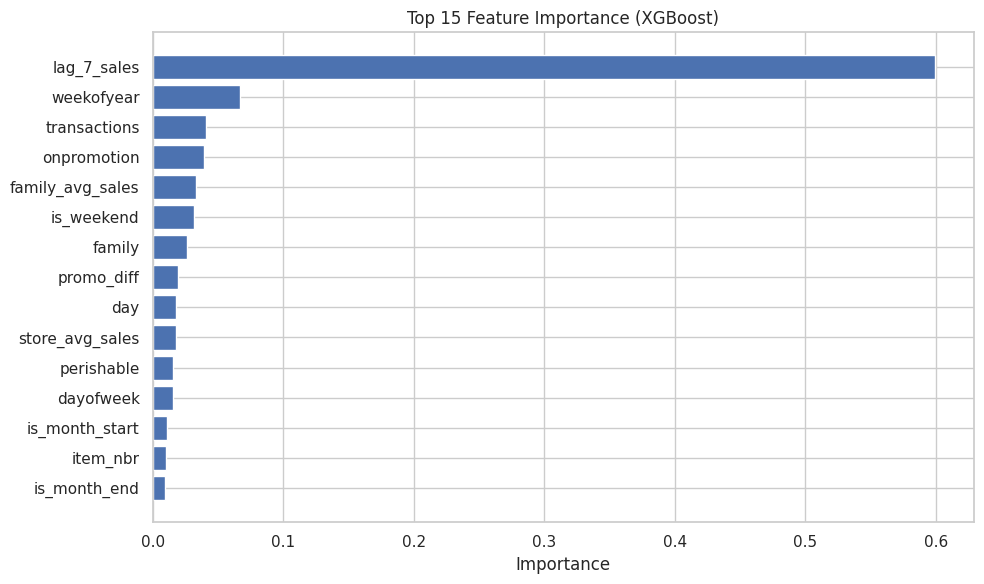


Top 15 Feature quan trọng nhất:
             Feature  Importance
0        lag_7_sales    0.599209
1         weekofyear    0.066416
2       transactions    0.040583
3        onpromotion    0.038880
4   family_avg_sales    0.032814
5         is_weekend    0.031916
6             family    0.026326
7         promo_diff    0.019219
8                day    0.017568
9    store_avg_sales    0.017520
10        perishable    0.015705
11         dayofweek    0.015131
12    is_month_start    0.010818
13          item_nbr    0.009803
14      is_month_end    0.009316


In [68]:
# ===== Chọn top-15 feature importance =====
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Chuẩn hóa tên cột
train_fe.rename(columns={"type_x": "store_type", "type_y": "holiday_type"}, inplace=True)

# Danh sách feature hợp lệ
selected_features = [
    "store_nbr", "item_nbr", "onpromotion", "transactions", "dcoilwtico",
    "family", "perishable", "city", "state",
    "store_type", "holiday_type",
    "year", "month", "day", "dayofweek", "weekofyear", "is_weekend",
    "quarter", "is_month_start", "is_month_end", "season",
    "store_avg_sales", "family_avg_sales", "lag_7_sales", "promo_diff"
]

# Lấy mẫu nhỏ để train
sample_df = train_fe.sample(500_000, random_state=42)
X = sample_df[selected_features].copy()
y = sample_df["log_sales"].copy()

# Encode object → category → int
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category").cat.codes

# Train XGBoost nhẹ để phân tích feature importance
xgb = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X, y)

# Phân tích độ quan trọng
importance_df = (
    pd.DataFrame({
        "Feature": selected_features,
        "Importance": xgb.feature_importances_
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

# Lọc top-15 feature
top_features = importance_df["Feature"].head(15).tolist()
top_features.append("log_sales")
print("Top features được giữ lại:", top_features)

# Tạo và lưu file final top features
train_final_top_features = train_fe[top_features].copy()
final_path = "/kaggle/working/train_final_top_features.csv"
train_final_top_features.to_csv(final_path, index=False)

print(f"Đã lưu file train_final_top_features tại: {final_path}")
print("Kích thước:", train_final_top_features.shape)

# Hiển thị biểu đồ top-15 feature
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(15)[::-1],
          importance_df["Importance"].head(15)[::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# In bảng importance
print("\nTop 15 Feature quan trọng nhất:")
print(importance_df.head(15))

In [69]:
# ===== Giải phóng bộ nhớ để tránh tràn =====
del train_fe, train_merged, X, y, xgb
import gc; gc.collect()
print("Đã xoá toàn bộ biến nặng trong RAM.")

Đã xoá toàn bộ biến nặng trong RAM.


In [70]:
# Tạo biến train_final từ bộ feature đã chọn (train_final_top_features)
train_final = train_final_top_features.copy()
print("train_final shape:", train_final.shape)

train_final shape: (19280741, 16)


## Tối ưu hóa dung lượng

In [73]:
for col in train_final.select_dtypes(include="int64").columns:
    train_final[col] = pd.to_numeric(train_final[col], downcast="integer")

for col in train_final.select_dtypes(include="float64").columns:
    train_final[col] = pd.to_numeric(train_final[col], downcast="float")

print("Đã giảm dung lượng. Kích thước mới:")
train_final.info(memory_usage="deep")
train_final.head()

Đã giảm dung lượng. Kích thước mới:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19280741 entries, 0 to 19280740
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   lag_7_sales       float32
 1   weekofyear        int8   
 2   transactions      int16  
 3   onpromotion       int8   
 4   family_avg_sales  float32
 5   is_weekend        int8   
 6   family            int8   
 7   promo_diff        float32
 8   day               int32  
 9   store_avg_sales   float32
 10  perishable        int8   
 11  dayofweek         int32  
 12  is_month_start    int8   
 13  item_nbr          int32  
 14  is_month_end      int8   
 15  log_sales         float32
dtypes: float32(5), int16(1), int32(3), int8(7)
memory usage: 753.9 MB


,lag_7_sales,weekofyear,transactions,onpromotion,family_avg_sales,is_weekend,family,promo_diff,day,store_avg_sales,perishable,dayofweek,is_month_start,item_nbr,is_month_end,log_sales
0,0.0,52,1642,0,6.958411,1,12,NaN,1,5.619403,0,6,1,99197,0,0.693147
1,0.0,52,1642,0,8.376701,1,5,NaN,1,5.619403,1,6,1,103665,0,2.079442
2,0.0,52,1642,0,6.958411,1,12,NaN,1,5.619403,0,6,1,105574,0,0.693147
3,0.0,52,1642,0,6.958411,1,12,NaN,1,5.619403,0,6,1,105857,0,1.609438
4,0.0,52,1642,0,6.958411,1,12,NaN,1,5.619403,0,6,1,106716,0,1.098612


## Các model Machine Learning


### Tạo X,y và chia tập train/test

In [79]:
from sklearn.model_selection import train_test_split

X = train_final.drop(columns=["log_sales"])
y = train_final["log_sales"]

# Chia train/test theo tỉ lệ 8:2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, " | Test:", X_test.shape)

Train: (15424592, 15)  | Test: (3856149, 15)


### Train và so sánh 2 mô hình Machine Learning

In [80]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# ===== Hàm tiện ích đánh giá =====
def evaluate_model(name, y_true, y_pred, start_time):
    """
    Đánh giá mô hình và trả về (rmse, mae, r2)
    """
    elapsed = (time.time() - start_time) / 60  # phút
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print(f"Thời gian train + predict: {elapsed:.2f} phút")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    return rmse, mae, r2

# ===== Linear Regression =====
start = time.time()
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
rmse_lr, mae_lr, r2_lr = evaluate_model("Linear Regression", y_test, pred_lr, start)

# ===== XGBoost Regressor =====
start = time.time()
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
rmse_xgb, mae_xgb, r2_xgb = evaluate_model("XGBoost Regressor", y_test, pred_xgb, start)

results_df = pd.DataFrame([
    {"Model": "Linear Regression", "RMSE": rmse_lr, "MAE": mae_lr, "R2": r2_lr},
    {"Model": "XGBoost Regressor", "RMSE": rmse_xgb, "MAE": mae_xgb, "R2": r2_xgb}
]).sort_values("RMSE")

print("\nSo sánh kết quả:")
print(results_df)


Linear Regression
Thời gian train + predict: 0.24 phút
RMSE: 0.6594 | MAE: 0.5149 | R²: 0.4309

XGBoost Regressor
Thời gian train + predict: 4.86 phút
RMSE: 0.5927 | MAE: 0.4656 | R²: 0.5402

So sánh kết quả:
               Model      RMSE       MAE        R2
1  XGBoost Regressor  0.592669  0.465604  0.540235
0  Linear Regression  0.659370  0.514935  0.430926


## Các model Deep Learning

### Chuẩn bị dữ liệu & DataLoader

In [81]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np

# ===== Chuyển dữ liệu sang tensor =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_np = y_train.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.float32)

# ===== Định nghĩa Dataset tuỳ chỉnh =====
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SalesDataset(X_train_scaled, y_train_np)
test_ds  = SalesDataset(X_test_scaled, y_test_np)

# ===== Tạo DataLoader =====
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

print(f"DataLoader sẵn sàng: {len(train_loader)} batch train | {len(test_loader)} batch test")

DataLoader sẵn sàng: 30127 batch train | 7532 batch test


### Huấn luyện MLP (Fully Connected Network)

In [82]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===== Định nghĩa mô hình MLP =====
class MLPModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

mlp = MLPModel(X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

# ===== Train loop =====
epochs = 30
mlp.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        xb, yb = xb.to(device), yb.to(device).view(-1, 1)
        pred = mlp(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.5f}")

Device: cuda


Epoch 1/30: 100%|██████████| 30127/30127 [01:57<00:00, 256.14it/s]


Epoch 1: Loss = 0.37558


Epoch 2/30: 100%|██████████| 30127/30127 [01:54<00:00, 262.77it/s]


Epoch 2: Loss = 0.36926


Epoch 3/30: 100%|██████████| 30127/30127 [01:57<00:00, 255.96it/s]


Epoch 3: Loss = 0.36792


Epoch 4/30: 100%|██████████| 30127/30127 [01:49<00:00, 274.72it/s]


Epoch 4: Loss = 0.36709


Epoch 5/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.41it/s]


Epoch 5: Loss = 0.36658


Epoch 6/30: 100%|██████████| 30127/30127 [01:49<00:00, 275.52it/s]


Epoch 6: Loss = 0.36614


Epoch 7/30: 100%|██████████| 30127/30127 [01:49<00:00, 274.21it/s]


Epoch 7: Loss = 0.36584


Epoch 8/30: 100%|██████████| 30127/30127 [01:50<00:00, 272.52it/s]


Epoch 8: Loss = 0.36555


Epoch 9/30: 100%|██████████| 30127/30127 [01:49<00:00, 274.13it/s]


Epoch 9: Loss = 0.36535


Epoch 10/30: 100%|██████████| 30127/30127 [01:54<00:00, 261.98it/s]


Epoch 10: Loss = 0.36518


Epoch 11/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.46it/s]


Epoch 11: Loss = 0.36497


Epoch 12/30: 100%|██████████| 30127/30127 [01:49<00:00, 274.27it/s]


Epoch 12: Loss = 0.36480


Epoch 13/30: 100%|██████████| 30127/30127 [01:56<00:00, 259.62it/s]


Epoch 13: Loss = 0.36465


Epoch 14/30: 100%|██████████| 30127/30127 [01:54<00:00, 262.91it/s]


Epoch 14: Loss = 0.36450


Epoch 15/30: 100%|██████████| 30127/30127 [01:49<00:00, 274.19it/s]


Epoch 15: Loss = 0.36439


Epoch 16/30: 100%|██████████| 30127/30127 [01:49<00:00, 273.98it/s]


Epoch 16: Loss = 0.36429


Epoch 17/30: 100%|██████████| 30127/30127 [01:54<00:00, 263.07it/s]


Epoch 17: Loss = 0.36421


Epoch 18/30: 100%|██████████| 30127/30127 [01:54<00:00, 262.33it/s]


Epoch 18: Loss = 0.36405


Epoch 19/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.06it/s]


Epoch 19: Loss = 0.36406


Epoch 20/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.80it/s]


Epoch 20: Loss = 0.36396


Epoch 21/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.46it/s]


Epoch 21: Loss = 0.36390


Epoch 22/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.23it/s]


Epoch 22: Loss = 0.36387


Epoch 23/30: 100%|██████████| 30127/30127 [01:50<00:00, 273.15it/s]


Epoch 23: Loss = 0.36378


Epoch 24/30: 100%|██████████| 30127/30127 [01:55<00:00, 259.73it/s]


Epoch 24: Loss = 0.36370


Epoch 25/30: 100%|██████████| 30127/30127 [01:55<00:00, 261.46it/s]


Epoch 25: Loss = 0.36357


Epoch 26/30: 100%|██████████| 30127/30127 [01:55<00:00, 261.22it/s]


Epoch 26: Loss = 0.36352


Epoch 27/30: 100%|██████████| 30127/30127 [01:50<00:00, 272.09it/s]


Epoch 27: Loss = 0.36340


Epoch 28/30: 100%|██████████| 30127/30127 [01:54<00:00, 263.19it/s]


Epoch 28: Loss = 0.36330


Epoch 29/30: 100%|██████████| 30127/30127 [01:49<00:00, 274.52it/s]


Epoch 29: Loss = 0.36321


Epoch 30/30: 100%|██████████| 30127/30127 [01:50<00:00, 271.92it/s]

Epoch 30: Loss = 0.36317


### Đánh giá MLP

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlp.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = mlp(xb).cpu().numpy().flatten()
        preds.append(pred)
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

rmse_mlp = np.sqrt(mean_squared_error(trues, preds))
mae_mlp = mean_absolute_error(trues, preds)
r2_mlp = r2_score(trues, preds)

print("\nMLP Evaluation:")
print(f"RMSE: {rmse_mlp:.4f} | MAE: {mae_mlp:.4f} | R²: {r2_mlp:.4f}")


MLP Evaluation:
RMSE: 0.6088 | MAE: 0.4846 | R²: 0.5149


### Huấn luyện LSTM (1 bước, dạng chuỗi)

In [84]:
# ===== Chuẩn bị dữ liệu 3D cho LSTM =====
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm  = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

train_ds_lstm = SalesDataset(X_train_lstm, y_train_np)
test_ds_lstm  = SalesDataset(X_test_lstm, y_test_np)

train_loader_lstm = DataLoader(train_ds_lstm, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
test_loader_lstm  = DataLoader(test_ds_lstm, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

# ===== Định nghĩa LSTM model =====
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout_rate=0.2):
        super().__init__()
        # Tăng hidden_dim lên 128 và thêm 2 lớp LSTM
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_rate
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        # h_n shape: (num_layers, batch_size, hidden_dim)
        _, (h_n, _) = self.lstm(x)
        
        # Lấy hidden state của lớp cuối cùng (h_n[-1])
        return self.fc(h_n[-1])

lstm = LSTMModel(X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-4)

# ===== Train loop =====
epochs = 8
lstm.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in tqdm(train_loader_lstm, desc=f"LSTM Epoch {epoch+1}/{epochs}"):
        xb, yb = xb.to(device), yb.to(device).view(-1, 1)
        pred = lstm(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader_lstm):.5f}")

LSTM Epoch 1/8: 100%|██████████| 30127/30127 [02:20<00:00, 214.16it/s]


Epoch 1: Loss = 0.38171


LSTM Epoch 2/8: 100%|██████████| 30127/30127 [02:14<00:00, 223.85it/s]


Epoch 2: Loss = 0.37490


LSTM Epoch 3/8: 100%|██████████| 30127/30127 [02:17<00:00, 218.66it/s]


Epoch 3: Loss = 0.37460


LSTM Epoch 4/8: 100%|██████████| 30127/30127 [02:15<00:00, 221.89it/s]


Epoch 4: Loss = 0.37454


LSTM Epoch 5/8: 100%|██████████| 30127/30127 [02:14<00:00, 224.34it/s]


Epoch 5: Loss = 0.37437


LSTM Epoch 6/8: 100%|██████████| 30127/30127 [02:17<00:00, 219.74it/s]


Epoch 6: Loss = 0.37425


LSTM Epoch 7/8: 100%|██████████| 30127/30127 [02:14<00:00, 223.68it/s]


Epoch 7: Loss = 0.37430


LSTM Epoch 8/8: 100%|██████████| 30127/30127 [02:18<00:00, 218.15it/s]

Epoch 8: Loss = 0.37424


### Đánh giá LSTM

In [85]:
lstm.eval()
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader_lstm:
        xb = xb.to(device)
        pred = lstm(xb).cpu().numpy().flatten()
        preds.append(pred)
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

rmse_lstm = np.sqrt(mean_squared_error(trues, preds))
mae_lstm = mean_absolute_error(trues, preds)
r2_lstm = r2_score(trues, preds)

print("\nLSTM Evaluation:")
print(f"RMSE: {rmse_lstm:.4f} | MAE: {mae_lstm:.4f} | R²: {r2_lstm:.4f}")


LSTM Evaluation:
RMSE: 0.6105 | MAE: 0.4807 | R²: 0.5121


## So sánh các mô hình

In [86]:
results_all = pd.DataFrame([
    {"Model": "Linear Regression", "RMSE": rmse_lr, "MAE": mae_lr, "R2": r2_lr},
    {"Model": "XGBoost", "RMSE": rmse_xgb, "MAE": mae_xgb, "R2": r2_xgb},
    {"Model": "MLP (PyTorch)", "RMSE": rmse_mlp, "MAE": mae_mlp, "R2": r2_mlp},
    {"Model": "LSTM (PyTorch)", "RMSE": rmse_lstm, "MAE": mae_lstm, "R2": r2_lstm}
]).sort_values("RMSE")

print("\nSo sánh toàn bộ mô hình:")
print(results_all)


So sánh toàn bộ mô hình:
               Model      RMSE       MAE        R2
1            XGBoost  0.592669  0.465604  0.540235
2      MLP (PyTorch)  0.608792  0.484616  0.514880
3     LSTM (PyTorch)  0.610547  0.480728  0.512079
0  Linear Regression  0.659370  0.514935  0.430926
